# EDA: Easy Data Augmentation
**EDA: Easy Data Augmentation Techniques for Boosting Performance on Text Classification Tasks**
https://github.com/jasonwei20/eda_nlp


In [1]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Implementation

In [2]:
# Easy data augmentation techniques for text classification
# Jason Wei and Kai Zou

import random
from random import shuffle
random.seed(1)

#stop words list
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
			'ours', 'ourselves', 'you', 'your', 'yours', 
			'yourself', 'yourselves', 'he', 'him', 'his', 
			'himself', 'she', 'her', 'hers', 'herself', 
			'it', 'its', 'itself', 'they', 'them', 'their', 
			'theirs', 'themselves', 'what', 'which', 'who', 
			'whom', 'this', 'that', 'these', 'those', 'am', 
			'is', 'are', 'was', 'were', 'be', 'been', 'being', 
			'have', 'has', 'had', 'having', 'do', 'does', 'did',
			'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
			'because', 'as', 'until', 'while', 'of', 'at', 
			'by', 'for', 'with', 'about', 'against', 'between',
			'into', 'through', 'during', 'before', 'after', 
			'above', 'below', 'to', 'from', 'up', 'down', 'in',
			'out', 'on', 'off', 'over', 'under', 'again', 
			'further', 'then', 'once', 'here', 'there', 'when', 
			'where', 'why', 'how', 'all', 'any', 'both', 'each', 
			'few', 'more', 'most', 'other', 'some', 'such', 'no', 
			'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
			'very', 's', 't', 'can', 'will', 'just', 'don', 
			'should', 'now', '']

#cleaning up text
import re
def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

########################################################################
# Synonym replacement
# Replace n words in the sentence with synonyms from wordnet
########################################################################

#for the first time you use wordnet
#import nltk
#nltk.download('wordnet')
from nltk.corpus import wordnet 

def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words if word not in stop_words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			#print("replaced", random_word, "with", synonym)
			num_replaced += 1
		if num_replaced >= n: #only replace up to n words
			break

	#this is stupid but we need it, trust me
	sentence = ' '.join(new_words)
	new_words = sentence.split(' ')

	return new_words

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name().replace("_", " ").replace("-", " ").lower()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################

def random_deletion(words, p):

	#obviously, if there's only one word, don't delete it
	if len(words) == 1:
		return words

	#randomly delete words with probability p
	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	#if you end up deleting all words, just return a random word
	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################

def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)
	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0
	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words
	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################

def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	return new_words

def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		random_word = new_words[random.randint(0, len(new_words)-1)]
		synonyms = get_synonyms(random_word)
		counter += 1
		if counter >= 10:
			return
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)

########################################################################
# main data augmentation function
########################################################################

def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=9):
	
	sentence = get_only_chars(sentence)
	words = sentence.split(' ')
	words = [word for word in words if word is not '']
	num_words = len(words)
	
	augmented_sentences = []
	num_new_per_technique = int(num_aug/4)+1

	#sr
	if (alpha_sr > 0):
		n_sr = max(1, int(alpha_sr*num_words))
		for _ in range(num_new_per_technique):
			a_words = synonym_replacement(words, n_sr)
			augmented_sentences.append(' '.join(a_words))

	#ri
	if (alpha_ri > 0):
		n_ri = max(1, int(alpha_ri*num_words))
		for _ in range(num_new_per_technique):
			a_words = random_insertion(words, n_ri)
			augmented_sentences.append(' '.join(a_words))

	#rs
	if (alpha_rs > 0):
		n_rs = max(1, int(alpha_rs*num_words))
		for _ in range(num_new_per_technique):
			a_words = random_swap(words, n_rs)
			augmented_sentences.append(' '.join(a_words))

	#rd
	if (p_rd > 0):
		for _ in range(num_new_per_technique):
			a_words = random_deletion(words, p_rd)
			augmented_sentences.append(' '.join(a_words))

	augmented_sentences = [get_only_chars(sentence) for sentence in augmented_sentences]
	# shuffle(augmented_sentences)

	#trim so that we have the desired number of augmented sentences
	if num_aug >= 1:
	  augmented_sentences = augmented_sentences[:num_aug]	  
	else:
		keep_prob = num_aug / len(augmented_sentences)
		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

	#append the original sentence
	# augmented_sentences.append(sentence)

	return augmented_sentences

In [3]:
import pandas as pd
from google.colab import drive
from nltk.corpus import stopwords
import nltk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

In [4]:
drive.mount('/content/drive', force_remount = True)
root_dir = '/content/drive/MyDrive/Toxic_comment_classification_Maggio_Monti/'
train = pd.read_csv(root_dir+'dataset/dataset_clean/train_clean.csv', index_col=0)
train = train.drop('id', axis=1)

Mounted at /content/drive


In [5]:
types = [row['toxic'] + row['severe_toxic'] + row['obscene'] + row['threat'] + row['insult'] + row['identity_hate']  for index, row in train.iterrows()]


In [6]:
train['types_count'] = types

In [7]:
count_dict = []
for column in train.columns[1:7]:
  count_dict.append((column, sum(train[train[column]==1][column])))
count_dict.sort(key=lambda tup: tup[1])
count_dict

[('threat', 478),
 ('identity_hate', 1405),
 ('severe_toxic', 1595),
 ('insult', 7877),
 ('obscene', 8449),
 ('toxic', 15294)]

In [8]:
# calcolo i pesi
totale_toxic = sum([x for (_,x) in count_dict])
for row in count_dict:
  print(f"{row[0]}: {round(totale_toxic/(row[1]*100),2)}")

threat: 0.73
identity_hate: 0.25
severe_toxic: 0.22
insult: 0.04
obscene: 0.04
toxic: 0.02


In [9]:
toxic_df = train[train['types_count']>0]

In [10]:
toxic_df.shape

(16225, 8)

In [11]:
weights = list(map(lambda a, b, c, d, e, f: (a*0.02+b*0.22+c*0.04+d*0.78+e*0.04+f*0.24), train[train['types_count']>0]['toxic'] , train[train['types_count']>0]['severe_toxic'], train[train['types_count']>0]['obscene'] , train[train['types_count']>0]['threat'] , train[train['types_count']>0]['insult'] , train[train['types_count']>0]['identity_hate']))


In [12]:
generated = toxic_df.sample(11000, replace=True, weights=weights)
generated

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,types_count
96608,hey fuck you you cocksucker i was talking to d...,1,0,1,0,1,0,3
39610,jforget fuck you faggot gay ass chink nigger c...,1,1,1,0,1,1,5
101909,oh yea i remenber the ugly matador coupes the ...,1,0,1,0,1,0,3
146199,sucker you suck the di k of chicken fuc ers,1,1,1,0,1,0,4
53224,bertie youre a stupid ignorant cunt do humanit...,1,0,1,1,1,0,4
...,...,...,...,...,...,...,...,...
112385,nigger was not exactly my choice of words if y...,1,0,0,0,0,1,2
104472,because i am a huge asshole,1,0,1,0,1,0,3
84611,wetodid is obviously stupid and knows nothing ...,1,0,0,0,1,0,2
132566,i hope you die you fucking pedophile i gave yo...,1,0,1,1,1,1,5


In [13]:
eda_expander = 10
sentences = []
toxic = []
severe_toxic = []
obscene = []
threat = []
insult = []
identity_hate = []
types_count = []

for index,row in generated.iterrows():
  for new_comment in eda(row['comment_text'], num_aug=eda_expander):
    sentences.append(new_comment)
    toxic.append(row['toxic'])
    severe_toxic.append(row['severe_toxic'])
    obscene.append(row['obscene'])
    threat.append(row['threat'])
    insult.append(row['insult'])
    identity_hate.append(row['identity_hate'])
    types_count.append(row['types_count'])


In [14]:
new_df = pd.DataFrame(list(zip(sentences,toxic,severe_toxic,obscene,threat,insult ,identity_hate,types_count)), columns=train.columns)
new_df.shape

(110000, 8)

In [ ]:
for x in new_df['comment_text']:
  if isinstance(x,float):
    print(x)

In [15]:
train = train.append(new_df, ignore_index=True)
train

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,types_count
0,explanation why the edits made under my userna...,0,0,0,0,0,0,0
1,daww he matches this background colour im seem...,0,0,0,0,0,0,0
2,hey man im really not trying to edit war its j...,0,0,0,0,0,0,0
3,more i cant make any real suggestions on impro...,0,0,0,0,0,0,0
4,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
269566,contd along scoundrel the block on padmalskhmi...,0,0,0,1,1,0,2
269567,contd discussion the block was padmalskhmi was...,0,0,0,1,1,0,2
269568,scoundrel contd the block on padmalskhmi was e...,0,0,0,1,1,0,2
269569,contd scoundrel the block on so was expired on...,0,0,0,1,1,0,2


In [16]:
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
neutral = []
offensive = []

for col in label_columns:
  temp_count = train[col].value_counts()
  neutral.append(temp_count[0])
  offensive.append(temp_count[1])
  
  print('-----------------------------')
  print('#', col.upper(), 'COMMENTS',':' , temp_count[1])


-----------------------------
# TOXIC COMMENTS : 120354
-----------------------------
# SEVERE_TOXIC COMMENTS : 38425
-----------------------------
# OBSCENE COMMENTS : 93189
-----------------------------
# THREAT COMMENTS : 25308
-----------------------------
# INSULT COMMENTS : 90657
-----------------------------
# IDENTITY_HATE COMMENTS : 33045


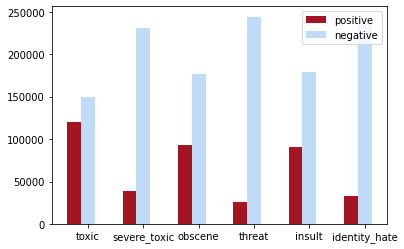

In [17]:
# Code to draw bar graph for visualising distribution of classes within each label.
barWidth = 0.25

r1 = np.arange(len(label_columns))
r2 = [x + barWidth for x in r1]

plt.bar(r1, offensive, color='#a31621', width=barWidth, label='positive')
plt.bar(r2, neutral, color='#bfdbf7', width=barWidth, label='negative')

# plt.xlabel('Categories', fontweight='bold')

plt.xticks([r + barWidth for r in range(len(label_columns))], label_columns)
plt.legend()
plt.show()

In [18]:
print(f"Percentuale di toxic comment: {round(train[train['types_count']>0].shape[0] * 100 / (train[train['types_count']>0].shape[0] + train[train['types_count']==0].shape[0]))}%")

Percentuale di toxic comment: 47%


In [19]:
print(f"Percentuale di non toxic comment: {round(train[train['types_count']==0].shape[0] * 100 / (train[train['types_count']>0].shape[0] + train[train['types_count']==0].shape[0]))}%")

Percentuale di non toxic comment: 53%


In [20]:
train.to_csv(root_dir+'dataset/dataset_augmented/train_augmented_balanced.csv')